In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory paths
train_dir = r"chest_xray\chest_xray\train"
test_dir = r"chest_xray\chest_xray\test"


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  
# Function to display images from a given directory
def display_images_from_directory(directory, label, n_images=5):
    label_dir = os.path.join(directory, label)
    images = os.listdir(label_dir)

    # Display the first n_images from the directory
    plt.figure(figsize=(20, 20))
    for i, img_name in enumerate(images[:n_images]):
        img_path = os.path.join(label_dir, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{label} Image")
        plt.axis('off')
    plt.show()


Displaying Normal images from training set:


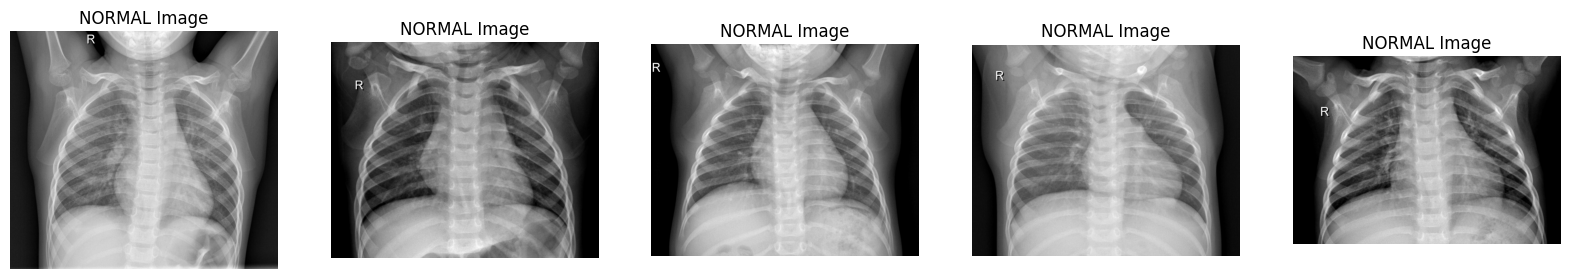

In [4]:
# Display images from the training set
print("Displaying Normal images from training set:")
display_images_from_directory(train_dir, 'NORMAL', n_images=5)



Displaying Pneumonia images from training set:


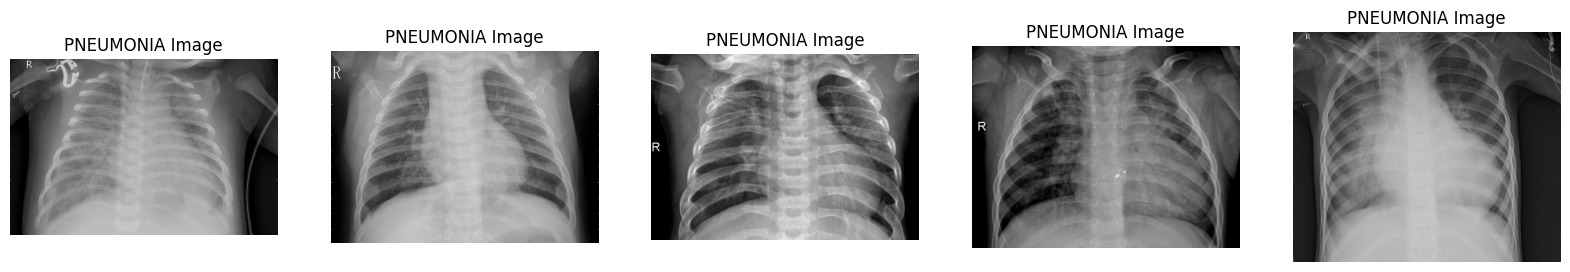

In [5]:
print("Displaying Pneumonia images from training set:")
display_images_from_directory(train_dir, 'PNEUMONIA', n_images=5)



Class distribution before balancing:


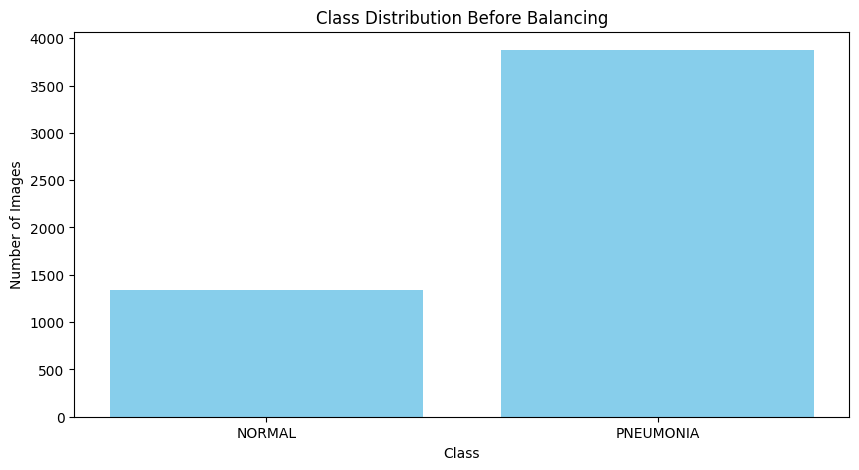

In [6]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(directory, title='Class Distribution'):
    # Initialize a Counter to count images in each class
    class_counts = Counter()
    
    # Iterate over each class directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count the number of files in the directory
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
    
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

    # Plot class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.show()

# Example usage:
print("Class distribution before balancing:")
plot_class_distribution(train_dir, 'Class Distribution Before Balancing')



Undersampling complete.
Class distribution after undersampling:


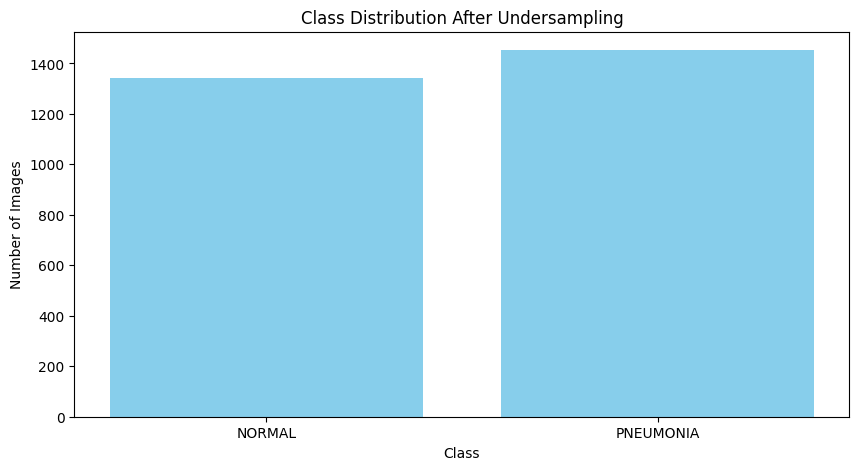

In [7]:
import os
import shutil
from collections import Counter
from sklearn.utils import resample

# Define the directory paths
undersampled_train_dir = r"chest_xray\chest_xray\undersampled_train"

# Determine the number of images to keep per class
def get_class_counts(directory):
    class_counts = Counter()
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
    return class_counts

# Get class counts for the original dataset
class_counts = get_class_counts(train_dir)
min_class_count = min(class_counts.values())

# Create a directory structure for the undersampled dataset
os.makedirs(undersampled_train_dir, exist_ok=True)
for class_name in os.listdir(train_dir):
    os.makedirs(os.path.join(undersampled_train_dir, class_name), exist_ok=True)

# Undersample the majority classes
def undersample_class(class_path, save_to_path, num_images_to_keep):
    images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
    if len(images) > num_images_to_keep:
        images = resample(images, n_samples=num_images_to_keep, random_state=42)
    for image_path in images:
        shutil.copy(image_path, os.path.join(save_to_path, os.path.basename(image_path)))

# Perform undersampling
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    save_to_path = os.path.join(undersampled_train_dir, class_name)
    # Increase the number of images to keep for the majority class
    num_images_to_keep = min_class_count + 500  # Adjust this number as needed
    undersample_class(class_path, save_to_path, num_images_to_keep)

print("Undersampling complete.")


print("Class distribution after undersampling:")
plot_class_distribution(undersampled_train_dir, 'Class Distribution After Undersampling')


In [10]:

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data augmentation and normalization for training
train_image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False, 
    fill_mode='nearest'
)

# Only normalization for validation/testing
test_image_gen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training dataset
train_data_gen = train_image_gen.flow_from_directory(
    undersampled_train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale', 
    class_mode='binary'
)

# Load and preprocess the testing dataset
test_data_gen = test_image_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale', 
    class_mode='binary'
)

Found 2794 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# LogisticRegression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np 

# Flatten images for Logistic Regression
def flatten_images(image_gen):
    images = []
    labels = []
    for i in range(len(image_gen)):
        batch = image_gen[i]
        images.extend(batch[0])
        labels.extend(batch[1])
    return np.array(images), np.array(labels)

train_images, train_labels = flatten_images(train_data_gen)
test_images, test_labels = flatten_images(test_data_gen)

# Create a Logistic Regression pipeline
log_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])



In [12]:

# Train and evaluate
log_reg.fit(train_images.reshape(train_images.shape[0], -1), train_labels)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(max_iter=1000))])

In [13]:
predictions = log_reg.predict(test_images.reshape(test_images.shape[0], -1))


In [14]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.54      0.62      0.58       234
         1.0       0.75      0.68      0.71       390

    accuracy                           0.66       624
   macro avg       0.64      0.65      0.65       624
weighted avg       0.67      0.66      0.66       624



In [15]:
from sklearn.metrics import  accuracy_score


# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)

# Print accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 65.87%


# Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Train and evaluate
dt_classifier.fit(train_images.reshape(train_images.shape[0], -1), train_labels)



DecisionTreeClassifier()

In [20]:
predictions_dt = dt_classifier.predict(test_images.reshape(test_images.shape[0], -1))


In [21]:
print(classification_report(test_labels, predictions_dt))

              precision    recall  f1-score   support

         0.0       0.64      0.73      0.68       234
         1.0       0.82      0.75      0.78       390

    accuracy                           0.74       624
   macro avg       0.73      0.74      0.73       624
weighted avg       0.75      0.74      0.74       624



In [22]:
from sklearn.metrics import  accuracy_score


# Calculate accuracy
accuracy_dt = accuracy_score(test_labels, predictions_dt)

# Print accuracy
print(f'Accuracy: {accuracy_dt * 100:.2f}%')

Accuracy: 74.20%


# Artificial Neural Network (ANN)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def build_ann_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [24]:

ann_model = build_ann_model((IMG_HEIGHT, IMG_WIDTH, 1))


c:\Users\kunch\Desktop\Chest_xray_project\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:

# Train and evaluate
history_ann = ann_model.fit(
    train_data_gen,
    epochs=10,
    validation_data=test_data_gen
)


Epoch 1/10


c:\Users\kunch\Desktop\Chest_xray_project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 446ms/step - accuracy: 0.5334 - loss: 3.1560 - val_accuracy: 0.6490 - val_loss: 0.6830
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 276ms/step - accuracy: 0.5727 - loss: 0.9325 - val_accuracy: 0.7212 - val_loss: 0.5812
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 299ms/step - accuracy: 0.6204 - loss: 0.8724 - val_accuracy: 0.6971 - val_loss: 0.5861
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.6395 - loss: 0.7100 - val_accuracy: 0.4311 - val_loss: 1.3497
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - accuracy: 0.6462 - loss: 0.7053 - val_accuracy: 0.6170 - val_loss: 0.7177
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.6941 - loss: 0.6116 - val_accuracy: 0.7372 - val_loss: 0.5139
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.6768 - loss: 0.6116 - val_accuracy: 0.6715 - val_loss: 0.6514
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.7270 - loss: 0.5705 - val_accuracy: 0.722

In [26]:
test_loss, test_acc = ann_model.evaluate(test_data_gen)
print(f'ANN Test accuracy: {test_acc:.2f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.6639 - loss: 0.6753
ANN Test accuracy: 0.65


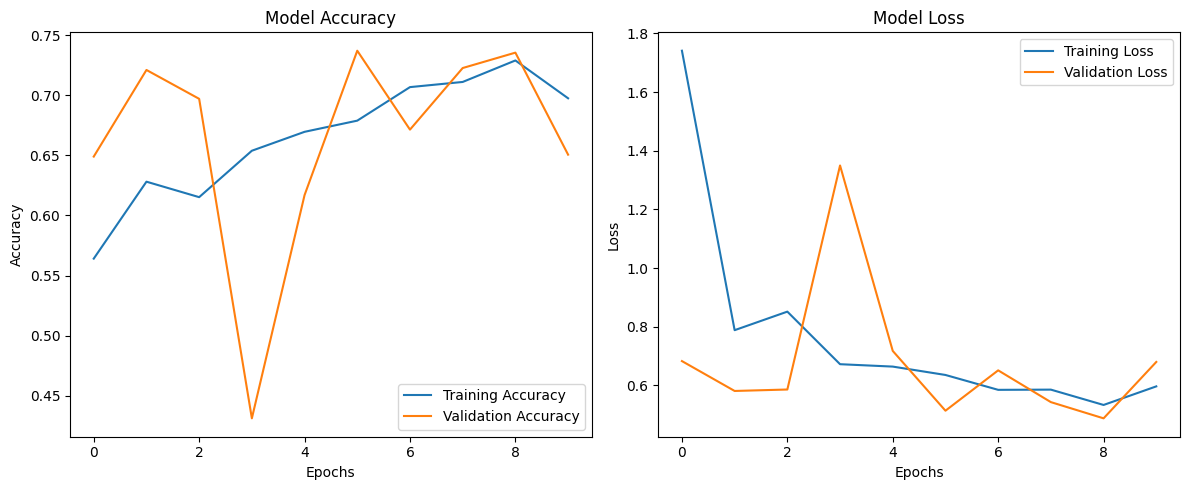

In [27]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ann.history['accuracy'], label='Training Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_ann.history['loss'], label='Training Loss')
plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


# CNN 

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [29]:
# Create and train the model
cnn_model = build_cnn_model((IMG_HEIGHT, IMG_WIDTH, 1))

history_cnn = cnn_model.fit(
    train_data_gen,
    epochs=10,
    validation_data=test_data_gen
)



c:\Users\kunch\Desktop\Chest_xray_project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 87s 883ms/step - accuracy: 0.6523 - loss: 0.6344 - val_accuracy: 0.8013 - val_loss: 0.4482
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 63s 700ms/step - accuracy: 0.8601 - loss: 0.3631 - val_accuracy: 0.6426 - val_loss: 0.6421
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 59s 610ms/step - accuracy: 0.8102 - loss: 0.4263 - val_accuracy: 0.8333 - val_loss: 0.3514
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 570ms/step - accuracy: 0.8626 - loss: 0.3516 - val_accuracy: 0.7981 - val_loss: 0.4601
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 570ms/step - accuracy: 0.8861 - loss: 0.3245 - val_accuracy: 0.8365 - val_loss: 0.3504
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 51s 563ms/step - accuracy: 0.8958 - loss: 0.2766 - val_accuracy: 0.8654 - val_loss: 0.3404
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 50s 547ms/step - accuracy: 0.9075 - loss: 0.2625 - val_accuracy: 0.8542 - val_loss: 0.3451
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 49s 546ms/step - accuracy: 0.9040 - loss: 0.2501 - val_accu

In [30]:
# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(test_data_gen)
print(f'CNN Test accuracy: {test_acc:.2f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.8797 - loss: 0.3766
CNN Test accuracy: 0.88


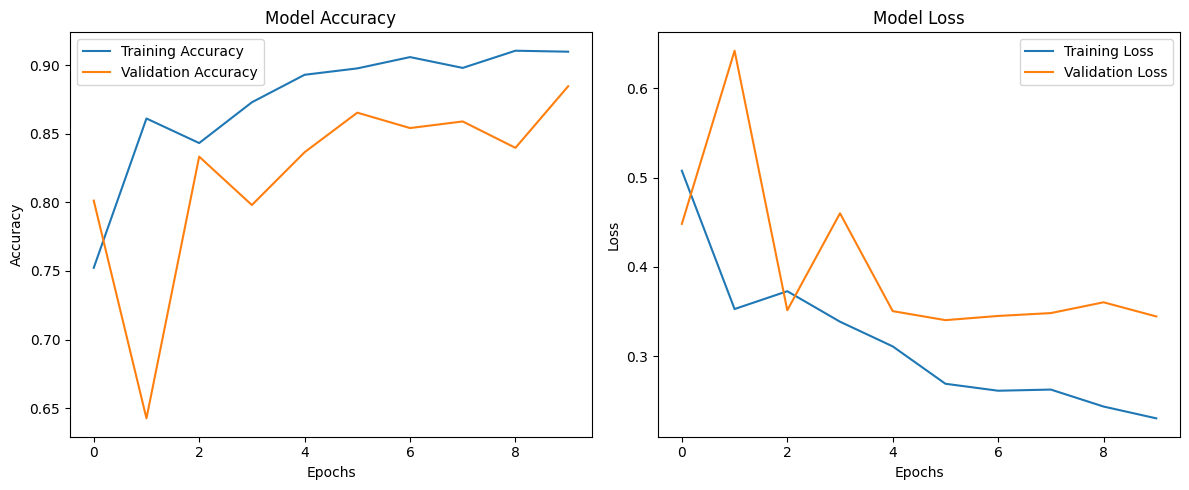

In [31]:

 
# Plotting accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


# Hyper Parameter Tuning

In [32]:
import keras_tuner as kt

def cnn_model_builder(hp):
    model = Sequential([
        Conv2D(hp.Int('conv_1_filters', min_value=64, max_value=128, step=32), (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=128, step=64), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=128, max_value=256, step=128), activation='relu'),
        Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model




In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_.keras', monitor='val_accuracy', save_best_only=True)



In [39]:
# Initialize Keras Tuner
tuner = kt.RandomSearch(
    cnn_model_builder,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='my_dir',
    project_name='image_classification_x_ray'
)

# Search for the best hyperparameters
tuner.search(train_data_gen, epochs=20, validation_data=test_data_gen, callbacks=[early_stopping, model_checkpoint])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [01h 23m 26s]
val_accuracy: 0.870192289352417

Best val_accuracy So Far: 0.870192289352417
Total elapsed time: 03h 16m 42s


c:\Users\kunch\Desktop\Chest_xray_project\venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
